# HSE 2024: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)



#### Loss Function:
$$
L(w, w_0) = \sum_{i=1}^N \left[ -y_i \log{\sigma(w^\top x_i)} - (1 - y_i) \log{(1 - \sigma(w^\top x_i))} \right] + \gamma \|w\|_1 + \beta \|w\|_2^2
$$
where:
- $$ \sigma(w^\top x_i) = \frac{1}{1 + e^{-w^\top x_i}} $$ is the sigmoid function.
- $$ \|w\|_1 = \sum_{j=1}^K |w_j| $$, and $$ \|w\|_2^2 = \sum_{j=1}^K w_j^2 $$.

---

### Gradient :

#### 1. **Logistic Loss Gradient:**
The derivative of the logistic loss (cross-entropy) for each \( x_i \) is:

$$
\frac{\partial}{\partial w} \left[ -y_i \log{\sigma(w^\top x_i)} - (1 - y_i) \log{(1 - \sigma(w^\top x_i))} \right] = \left( \sigma(w^\top x_i) - y_i \right) x_i
$$

 over all data points gives:

$$
\nabla_w L_{\text{logistic}} = \sum_{i=1}^N \left( \sigma(w^\top x_i) - y_i \right) x_i
$$
---

#### 2. **Gradient of \( L_2 \) Regularizer:**

$$
\nabla_w \|w\|_2^2 = 2w
$$

Including the coefficient $$ \beta $$, the contribution becomes:

$$
2 \beta w
$$

---

#### 3. **Subgradient of \( L_1 \) Regularizer:**


$$
\nabla_w \|w\|_1 = \text{sign}(w)
$$

where \( \text{sign}(w_j) \) is:
- \( 1 \) if \( w_j > 0 \),
- \( -1 \) if \( w_j < 0 \),
- Any value in \( [-1, 1] \) if \( w_j = 0 \).

Including the coefficient \( \gamma \), the contribution becomes:
$$
\gamma \, \text{sign}(w)
$$

---

#### 4. **Total Gradient:**
gathering all contributions, the gradient with respect to \( w \) is:

$$
\nabla_w L = \sum_{i=1}^N \left( \sigma(w^\top x_i) - y_i \right) x_i + \gamma \, \text{sign}(w) + 2 \beta w
$$

---

### Why ?

- **Logistic Loss:** This thing measures the error in predictions and gradients reflect how predictions deviate from actual labels.
- **Elastic Net Regularizer:** And this Ccmbines sparsity (\( L_1 \)) and smoothness (\( L_2 \)) to balance model interpretability and generalization.

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [2]:
import numpy as np
from typing import List

def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    # Sigmoid
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    # logistic loss
    y_pred = sigmoid(np.dot(X, w))
    logistic_loss = -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    #  Elastic Net regularization terms
    l1_term = gamma * np.sum(np.abs(w))
    l2_term = beta * np.sum(w**2)


    return logistic_loss + l1_term + l2_term


#### 3. [0.25 points] Implement the gradient (as a function)

In [3]:
from typing import Tuple

def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    # Sigmoid
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    # Predictions
    y_pred = sigmoid(np.dot(X, w))

    # Gradient of logistic loss
    grad_logistic = np.dot(X.T, (y_pred - y))

    # Gradient of Elastic Net regularizer
    grad_l1 = gamma * np.sign(w)
    grad_l2 = 2 * beta * w


    grad_w = grad_logistic + grad_l1 + grad_l2

    return grad_w


#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

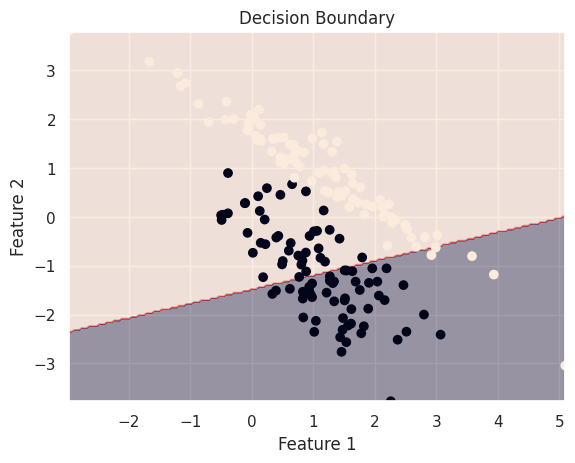

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=0.01, tolerance=0.01, max_iter=50000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        np.random.seed(self.random_state)

        # Standardize X
        self.scaler = StandardScaler()
        X = self.scaler.fit_transform(X)

        X = np.c_[np.ones(X.shape[0]), X]
        self.w = np.random.randn(X.shape[1])

        for iteration in range(self.max_iter):
            y_pred = self.sigmoid(np.dot(X, self.w))
            error = y_pred - y

            #  gradient
            grad_logistic = np.dot(X.T, error) / X.shape[0]
            grad_l1 = self.gamma * np.sign(self.w)
            grad_l2 = 2 * self.beta * self.w
            grad_total = grad_logistic + grad_l1 + grad_l2

            # weights
            w_old = self.w.copy()
            self.w -= self.learning_rate * grad_total

            # Check for convergence
            if np.linalg.norm(self.w - w_old, ord=1) < self.tolerance:
                break

        return self

    def predict(self, X):
        X = self.scaler.transform(X)
        X = np.c_[np.ones(X.shape[0]), X]
        return (self.sigmoid(np.dot(X, self.w)) >= 0.5).astype(int)

    def predict_proba(self, X):
        X = self.scaler.transform(X)
        X = np.c_[np.ones(X.shape[0]), X]
        prob = self.sigmoid(np.dot(X, self.w))
        return np.c_[1 - prob, prob]

# sample
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

model = Logit(beta=0, gamma=0, lr=0.01, tolerance=0.01, max_iter=50000)
model.fit(X, y)

plot_decision_boundary(model, X, y)


#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

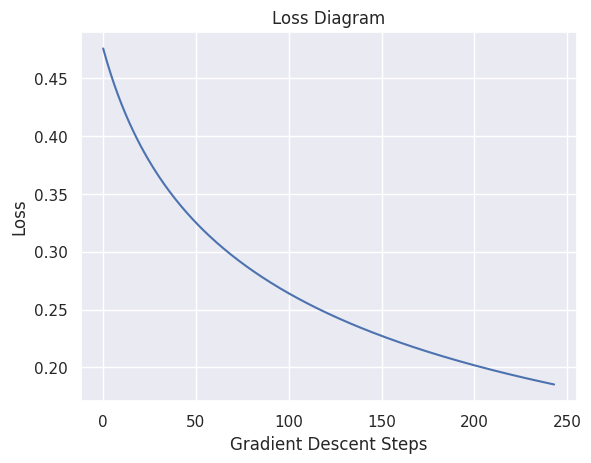

In [6]:
import matplotlib.pyplot as plt

class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=50000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w = None
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, X, y):
        y_pred = self.sigmoid(np.dot(X, self.w))
        logistic_loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        l1_term = self.gamma * np.sum(np.abs(self.w))
        l2_term = self.beta * np.sum(self.w**2)
        return logistic_loss + l1_term + l2_term

    def fit(self, X, y):
        np.random.seed(self.random_state)
        X = np.c_[np.ones(X.shape[0]), X]
        self.w = np.random.randn(X.shape[1])

        for iteration in range(self.max_iter):
            y_pred = self.sigmoid(np.dot(X, self.w))
            error = y_pred - y

            # the gradient
            grad_logistic = np.dot(X.T, error) / X.shape[0]
            grad_l1 = self.gamma * np.sign(self.w)
            grad_l2 = 2 * self.beta * self.w
            grad_total = grad_logistic + grad_l1 + grad_l2

            # weights
            w_old = self.w.copy()
            self.w -= self.learning_rate * grad_total

            # Store the loss for this iteration
            current_loss = self.compute_loss(X, y)
            self.loss_history.append(current_loss)

            # for convergence
            if np.linalg.norm(self.w - w_old, ord=1) < self.tolerance:
                break

        return self

    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return (self.sigmoid(np.dot(X, self.w)) >= 0.5).astype(int)

    def predict_proba(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        prob = self.sigmoid(np.dot(X, self.w))
        return np.c_[1 - prob, prob]


model = Logit(beta=0, gamma=0, lr=0.1, tolerance=0.01, max_iter=1000)
model.fit(X, y)


plt.plot(model.loss_history)
plt.xlabel("Gradient Descent Steps")
plt.ylabel("Loss")
plt.title("Loss Diagram")
plt.show()


## PART 2: Support Vector Machines



#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

    kernel      C  degree  gamma  accuracy   roc_auc  f1_score
0   linear    0.1     NaN    NaN  1.000000  1.000000  1.000000
1   linear    1.0     NaN    NaN  1.000000  1.000000  1.000000
2   linear   10.0     NaN    NaN  1.000000  1.000000  1.000000
3   linear  100.0     NaN    NaN  1.000000  1.000000  1.000000
4     poly    0.1     2.0    NaN  0.870370  0.972565  0.851064
5     poly    0.1     3.0    NaN  0.981481  1.000000  0.981132
6     poly    0.1     4.0    NaN  0.814815  0.998628  0.772727
7     poly    1.0     2.0    NaN  0.925926  1.000000  0.920000
8     poly    1.0     3.0    NaN  1.000000  1.000000  1.000000
9     poly    1.0     4.0    NaN  0.907407  0.998628  0.897959
10    poly   10.0     2.0    NaN  0.944444  1.000000  0.941176
11    poly   10.0     3.0    NaN  1.000000  1.000000  1.000000
12    poly   10.0     4.0    NaN  0.944444  1.000000  0.941176
13    poly  100.0     2.0    NaN  0.962963  0.998628  0.961538
14    poly  100.0     3.0    NaN  1.000000  1.000000  1

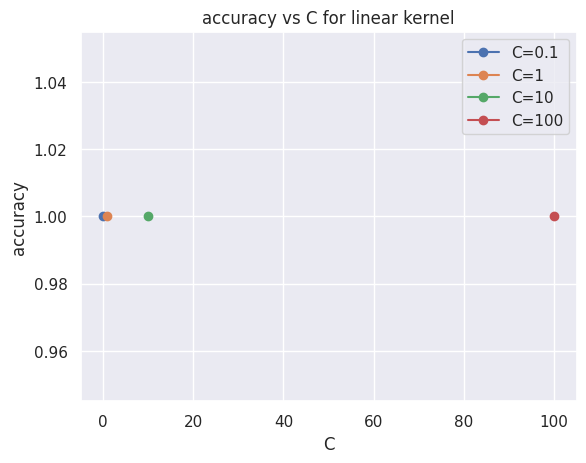

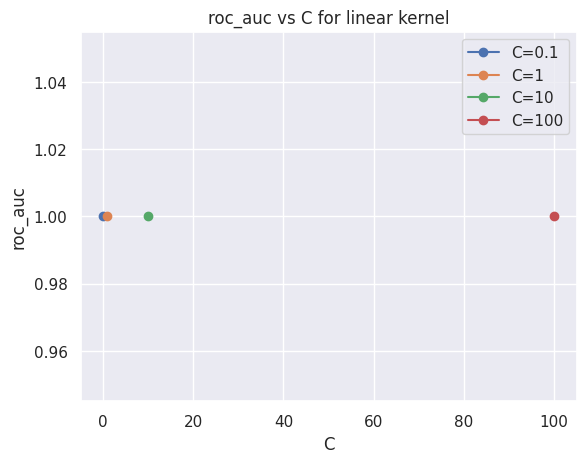

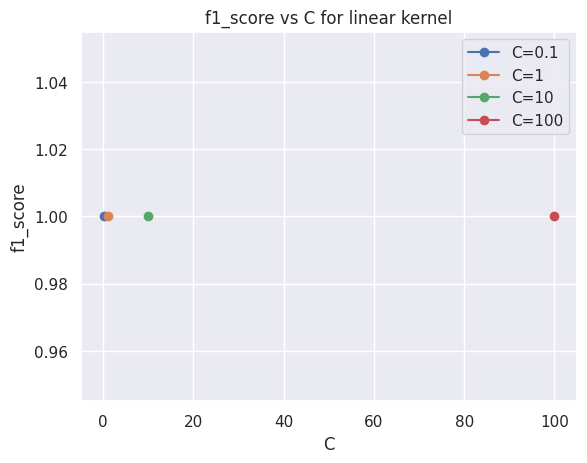

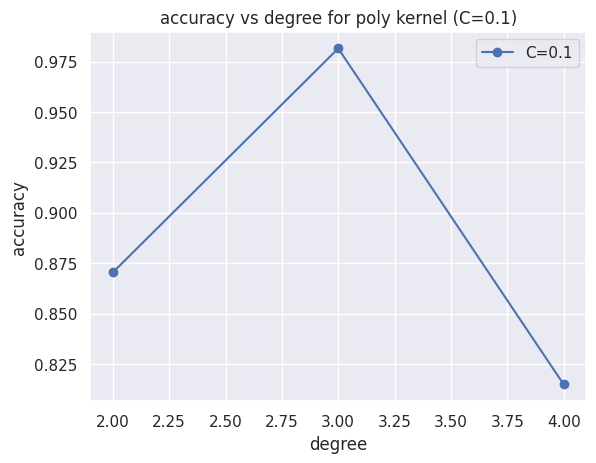

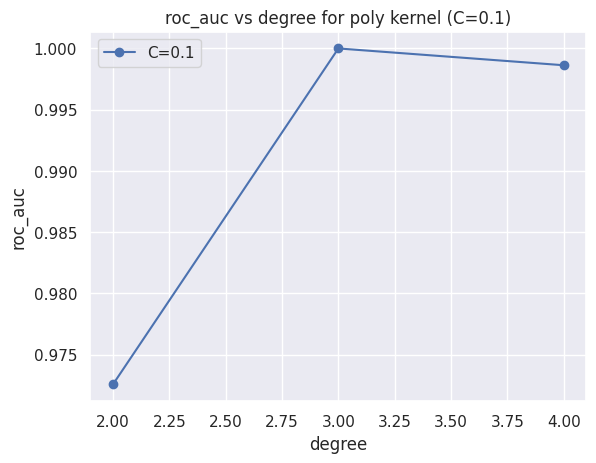

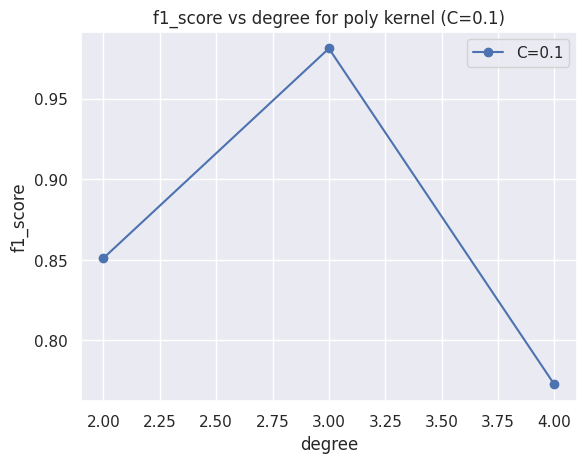

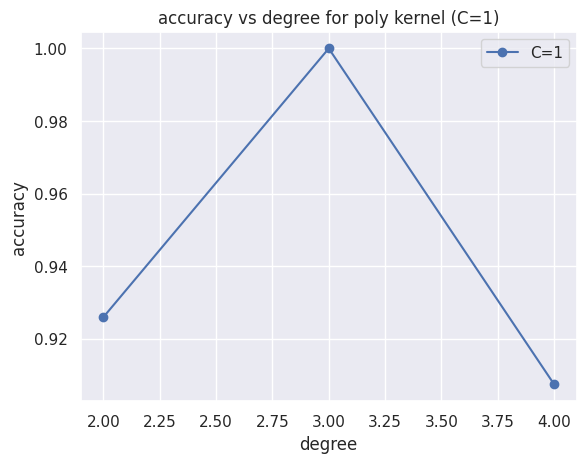

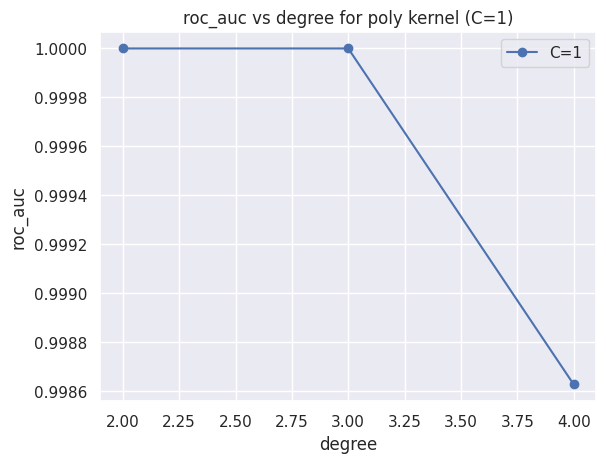

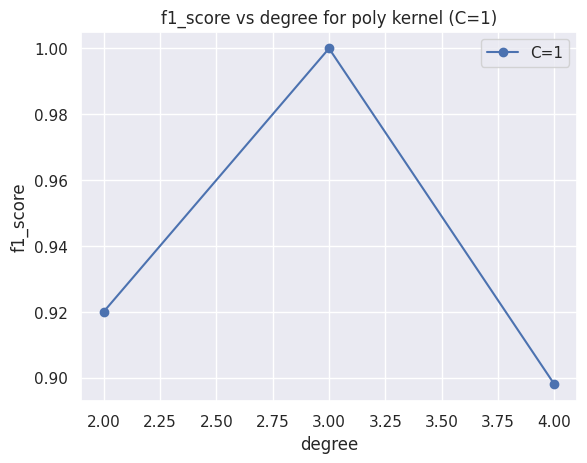

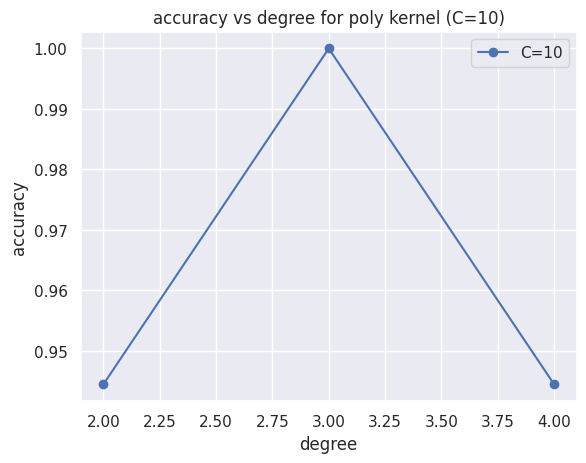

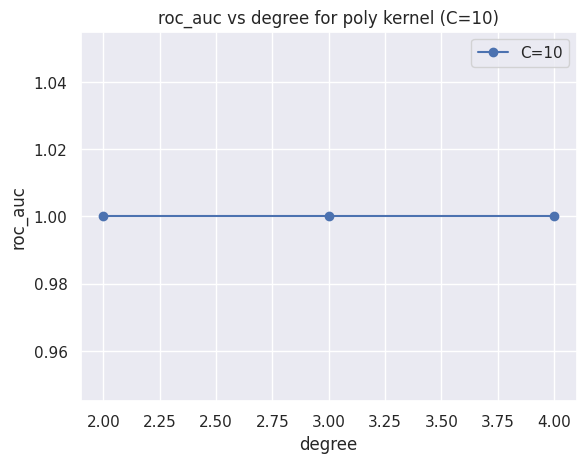

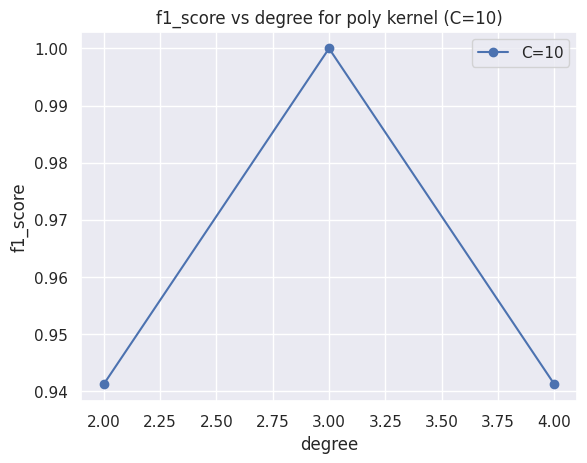

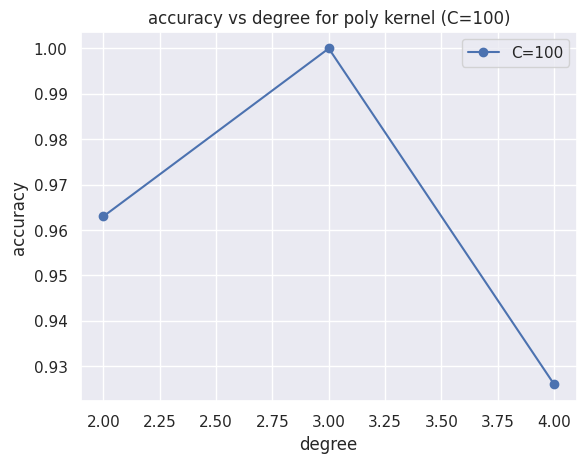

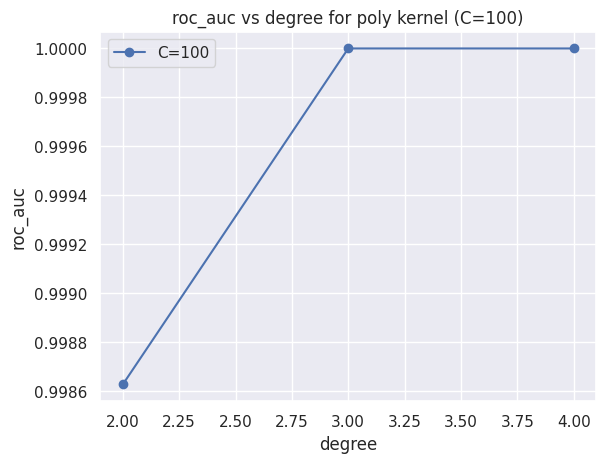

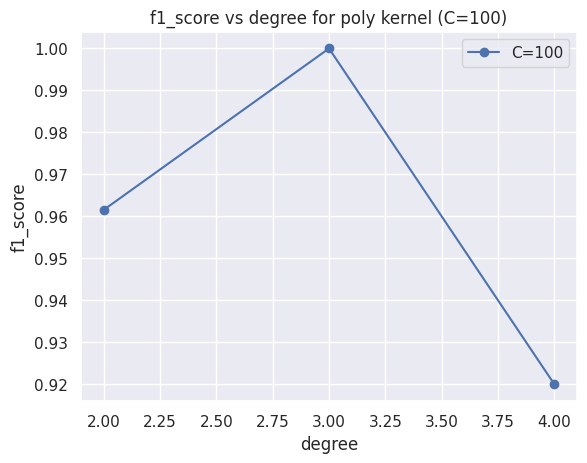

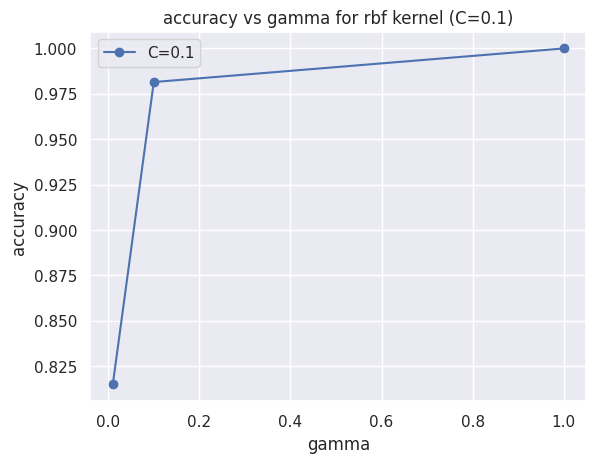

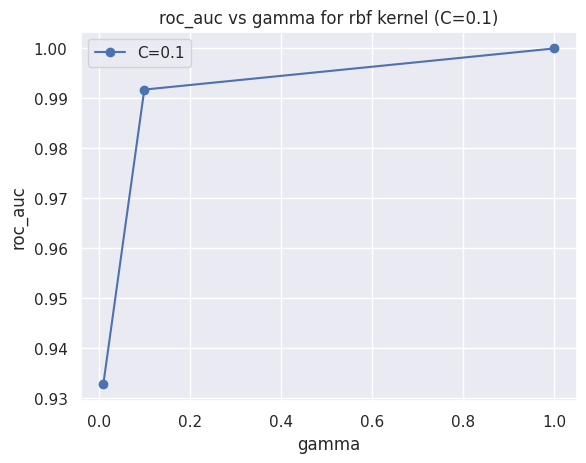

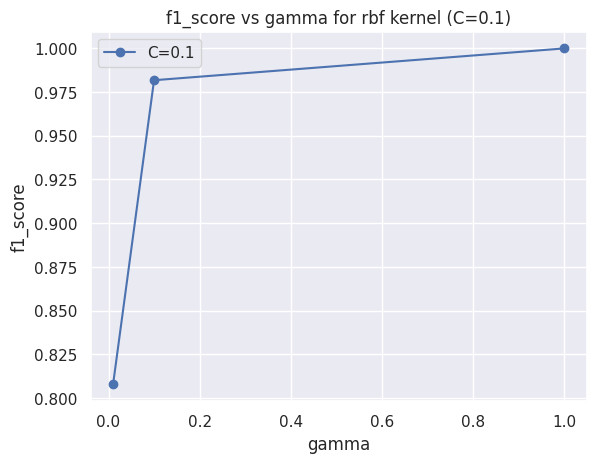

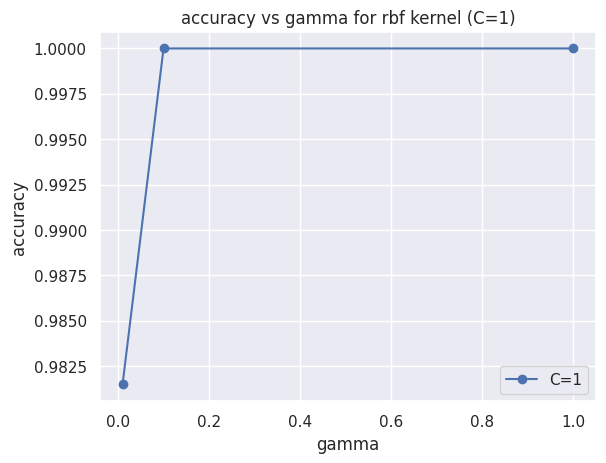

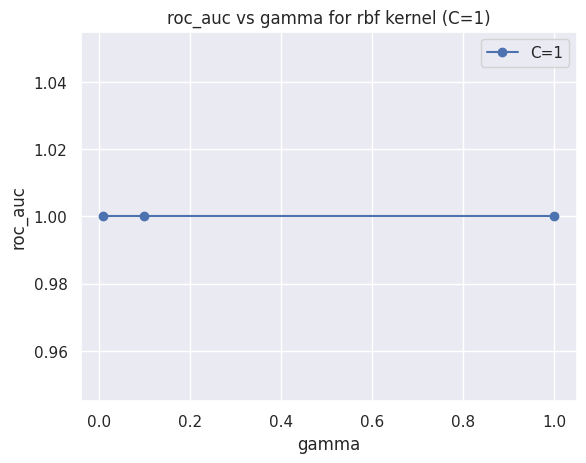

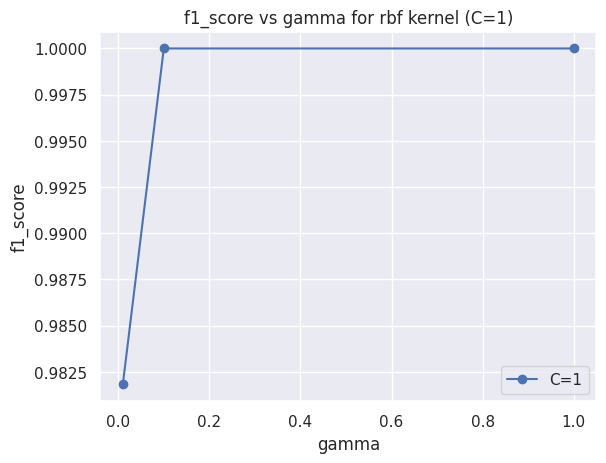

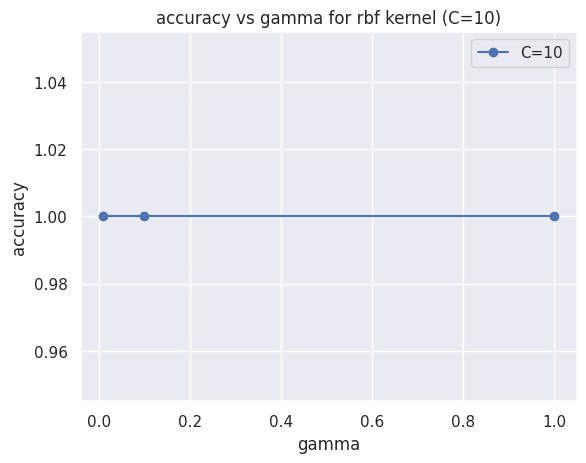

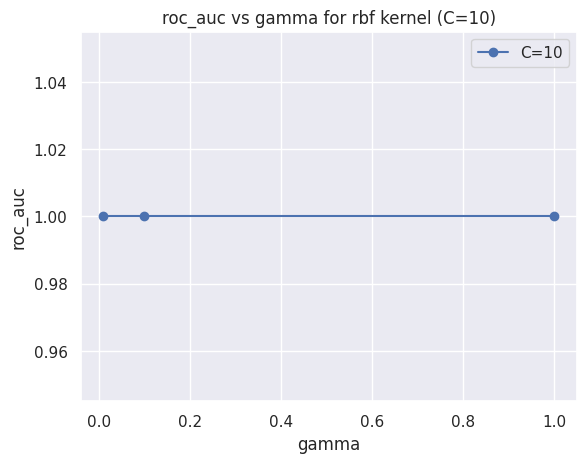

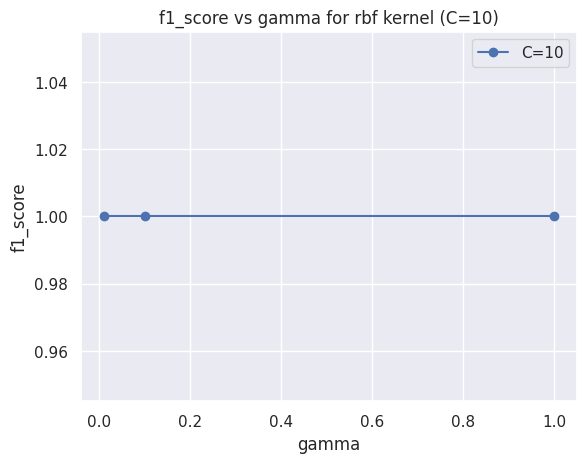

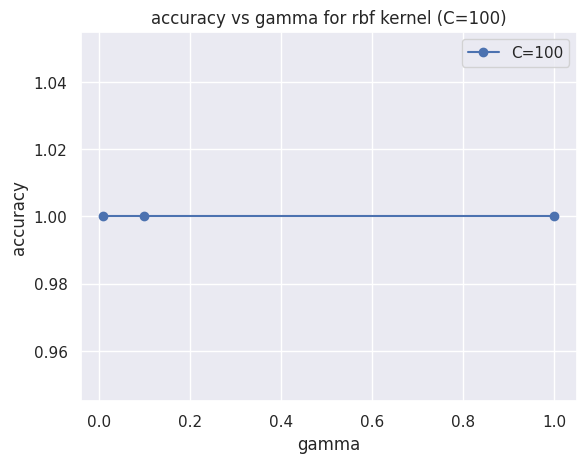

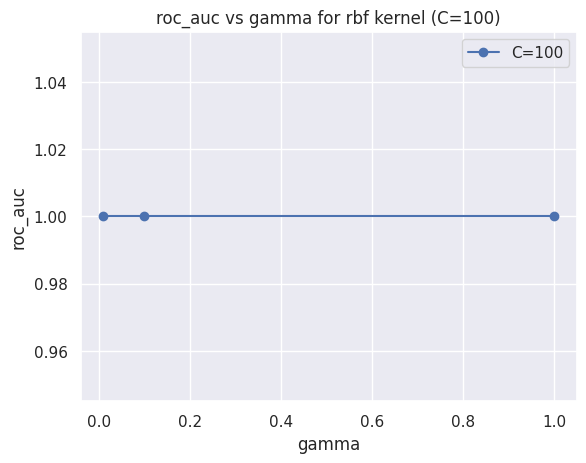

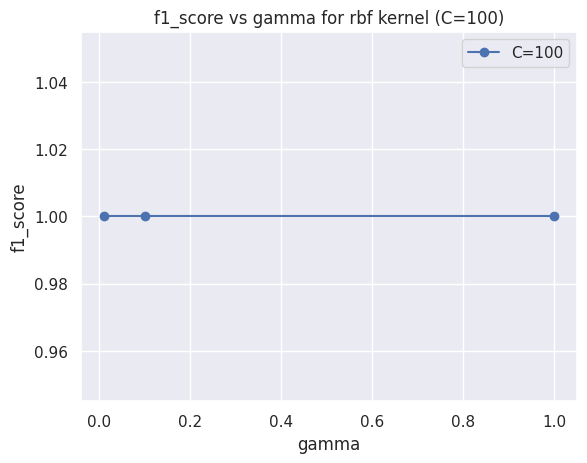

\ results for linear kernel:
   kernel      C  degree  gamma  accuracy  roc_auc  f1_score
0  linear    0.1     NaN    NaN       1.0      1.0       1.0
1  linear    1.0     NaN    NaN       1.0      1.0       1.0
2  linear   10.0     NaN    NaN       1.0      1.0       1.0
3  linear  100.0     NaN    NaN       1.0      1.0       1.0
\ results for poly kernel:
   kernel      C  degree  gamma  accuracy   roc_auc  f1_score
4    poly    0.1     2.0    NaN  0.870370  0.972565  0.851064
5    poly    0.1     3.0    NaN  0.981481  1.000000  0.981132
6    poly    0.1     4.0    NaN  0.814815  0.998628  0.772727
7    poly    1.0     2.0    NaN  0.925926  1.000000  0.920000
8    poly    1.0     3.0    NaN  1.000000  1.000000  1.000000
9    poly    1.0     4.0    NaN  0.907407  0.998628  0.897959
10   poly   10.0     2.0    NaN  0.944444  1.000000  0.941176
11   poly   10.0     3.0    NaN  1.000000  1.000000  1.000000
12   poly   10.0     4.0    NaN  0.944444  1.000000  0.941176
13   poly  100.0   

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# dataset for binary classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2, random_state=42, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# parameter ranges
C_values = [0.1, 1, 10, 100]
kernels = ['linear', 'poly', 'rbf']
degrees = [2, 3, 4]  # For polynomial kernel
gamma_values = [0.01, 0.1, 1]  # For RBF kernel

results = {
    'kernel': [],
    'C': [],
    'degree': [],
    'gamma': [],
    'accuracy': [],
    'roc_auc': [],
    'f1_score': []
}

for kernel in kernels:
    for C in C_values:
        if kernel == 'linear':
            # Linear kernel doesn't have degree or gamma hyperparameters
            model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]


            accuracy = accuracy_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)


            results['kernel'].append(kernel)
            results['C'].append(C)
            results['degree'].append(None)
            results['gamma'].append(None)
            results['accuracy'].append(accuracy)
            results['roc_auc'].append(roc_auc)
            results['f1_score'].append(f1)

        elif kernel == 'poly':
            for degree in degrees:
                model = SVC(kernel=kernel, C=C, degree=degree, probability=True, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]


                accuracy = accuracy_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba)
                f1 = f1_score(y_test, y_pred)


                results['kernel'].append(kernel)
                results['C'].append(C)
                results['degree'].append(degree)
                results['gamma'].append(None)
                results['accuracy'].append(accuracy)
                results['roc_auc'].append(roc_auc)
                results['f1_score'].append(f1)

        elif kernel == 'rbf':
            for gamma in gamma_values:
                model = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]


                accuracy = accuracy_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba)
                f1 = f1_score(y_test, y_pred)


                results['kernel'].append(kernel)
                results['C'].append(C)
                results['degree'].append(None)
                results['gamma'].append(gamma)
                results['accuracy'].append(accuracy)
                results['roc_auc'].append(roc_auc)
                results['f1_score'].append(f1)

results_df = pd.DataFrame(results)
print(results_df)


def plot_metric_vs_parameter(df, parameter, metric, kernel_type, fixed_param=None, fixed_value=None):
    subset = df[df['kernel'] == kernel_type]

    if fixed_param and fixed_value is not None:
        subset = subset[subset[fixed_param] == fixed_value]

    if subset.empty:
        print(f"No data available for kernel={kernel_type} with {fixed_param}={fixed_value}")
        return

    for c_value in C_values:
        subset_c = subset[subset['C'] == c_value]
        if not subset_c.empty:
            plt.plot(subset_c[parameter], subset_c[metric], label=f'C={c_value}', marker='o')

    plt.xlabel(parameter)
    plt.ylabel(metric)
    title = f'{metric} vs {parameter} for {kernel_type} kernel'
    if fixed_param and fixed_value is not None:
        title += f' ({fixed_param}={fixed_value})'
    plt.title(title)
    plt.legend()
    plt.show()


for kernel in kernels:
    if kernel == 'linear':

        plot_metric_vs_parameter(results_df, 'C', 'accuracy', kernel)
        plot_metric_vs_parameter(results_df, 'C', 'roc_auc', kernel)
        plot_metric_vs_parameter(results_df, 'C', 'f1_score', kernel)

    elif kernel == 'poly':

        for c_value in C_values:
            plot_metric_vs_parameter(results_df, 'degree', 'accuracy', kernel, 'C', c_value)
            plot_metric_vs_parameter(results_df, 'degree', 'roc_auc', kernel, 'C', c_value)
            plot_metric_vs_parameter(results_df, 'degree', 'f1_score', kernel, 'C', c_value)

    elif kernel == 'rbf':

        for c_value in C_values:
            plot_metric_vs_parameter(results_df, 'gamma', 'accuracy', kernel, 'C', c_value)
            plot_metric_vs_parameter(results_df, 'gamma', 'roc_auc', kernel, 'C', c_value)
            plot_metric_vs_parameter(results_df, 'gamma', 'f1_score', kernel, 'C', c_value)

for kernel in kernels:
    print(f"\ results for {kernel} kernel:")
    print(results_df[results_df['kernel'] == kernel])


In [8]:

print("Data Summary:")
print(results_df.head())

results_df.to_csv("SVM_results.csv", index=False)


Data Summary:
   kernel      C  degree  gamma  accuracy   roc_auc  f1_score
0  linear    0.1     NaN    NaN   1.00000  1.000000  1.000000
1  linear    1.0     NaN    NaN   1.00000  1.000000  1.000000
2  linear   10.0     NaN    NaN   1.00000  1.000000  1.000000
3  linear  100.0     NaN    NaN   1.00000  1.000000  1.000000
4    poly    0.1     2.0    NaN   0.87037  0.972565  0.851064


So the outputs i understood,

- **Linear Kernel:** Consistently achieves perfect metrics across all \( C \) values; shows no sensitivity to \( C \) changes on this dataset.

- **Polynomial Kernel:** Higher \( C \) and degree improve metrics, but high degree with high \( C \) lead to overfitting.

- **RBF Kernel:** Highly sensitive to gamma; moderate gamma balances performance, but high gamma with high \( C \) risks overfitting.

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

###Selected Authors:
Pushkin, Dostoevsky, Tolstoy, Chekhov, Gogol, and Turgenev.

###Because:
 Their significant impact on Russian literature and their distinctive styles.

In [9]:
import gdown
import shutil
import os

url = "https://drive.google.com/uc?id=1Bnf7v65QFQ9dA9P_R9w297YpP7n7N-Ld"
output = "/content/russian_literature.zip"
gdown.download(url, output, quiet=False)

extraction_path = "/content/russian_literature"
if os.path.exists(extraction_path):
    shutil.rmtree(extraction_path)

!mkdir -p {extraction_path}
!unzip -O CP866 {output} -d {extraction_path}

extracted_files = os.listdir(extraction_path)
print("Extracted files:", extracted_files)

Downloading...
From: https://drive.google.com/uc?id=1Bnf7v65QFQ9dA9P_R9w297YpP7n7N-Ld
To: /content/russian_literature.zip
100%|██████████| 20.4M/20.4M [00:00<00:00, 23.9MB/s]


Archive:  /content/russian_literature.zip
   creating: /content/russian_literature/archive/
  inflating: /content/russian_literature/__MACOSX/._archive  
  inflating: /content/russian_literature/archive/.DS_Store  
  inflating: /content/russian_literature/__MACOSX/archive/._.DS_Store  
  inflating: /content/russian_literature/archive/README.md  
  inflating: /content/russian_literature/__MACOSX/archive/._README.md  
   creating: /content/russian_literature/archive/poems/
  inflating: /content/russian_literature/__MACOSX/archive/._poems  
   creating: /content/russian_literature/archive/publicism/
  inflating: /content/russian_literature/__MACOSX/archive/._publicism  
   creating: /content/russian_literature/archive/prose/
  inflating: /content/russian_literature/__MACOSX/archive/._prose  
  inflating: /content/russian_literature/archive/Tolstoy_and_Chekhov_1901.jpg  
  inflating: /content/russian_literature/__MACOSX/archive/._Tolstoy_and_Chekhov_1901.jpg  
  inflating: /content/russian

In [10]:
import os

def display_directory_tree(startpath, level=0):
    for root, dirs, files in os.walk(startpath):
        depth = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * depth
        print(f"{indent}|-- {os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (depth + 1)
        for f in files:
            print(f"{sub_indent}|-- {f}")

extraction_path = "/content/russian_literature"
display_directory_tree(extraction_path)


|-- russian_literature/
    |-- archive/
        |-- README.md
        |-- Tolstoy_and_Chekhov_1901.jpg
        |-- .DS_Store
        |-- publicism/
            |-- .DS_Store
            |-- Tolstoy/
                |-- Доклад, приготовленный для конгресса о мире в Стокгольме.txt
                |-- О социализме.txt
                |-- Ответ польской женщине.txt
                |-- Церковь и государство.txt
                |-- Исповедь.txt
                |-- info.csv
                |-- Письмо студенту о праве.txt
                |-- Неделание.txt
                |-- По поводу заключения В.А. Молчникова.txt
                |-- Первая ступень.txt
                |-- О науке (Ответ  крестьянину).txt
                |-- Бессмысленные мечтания.txt
                |-- Письмо революционеру.txt
                |-- Приближение конца.txt
                |-- Студенческое движение 1899 года.txt
                |-- Не могу молчать (1-я редакция).txt
                |-- Две войны.txt
          

In [11]:
import os
import pandas as pd
import random
import re


prose_dir = "/content/russian_literature/archive/prose"


authors = {
    "Pushkin": 5000,
    "Dostoevsky": 15000,
    "Tolstoy": 8000,
    "Chekhov": 11000,
    "Gogol": 20000,
    "Turgenev": 3000
}


data = []


def custom_sent_tokenize(text):

    sentences = re.split(r'(?<=[.!?])\s+', text)
    return sentences


for author, sample_size in authors.items():
    author_dir = os.path.join(prose_dir, author)
    sentences = []

    # all files
    for file_name in os.listdir(author_dir):
        file_path = os.path.join(author_dir, file_name)
        if file_name.endswith(".txt"):
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()

                for sentence in custom_sent_tokenize(text):
                    # Clean and filter sentences with less than 15 characters
                    sentence = re.sub(r'\s+', ' ', sentence).strip()
                    if len(sentence) >= 15:
                        sentences.append(sentence)

    # Randomly sample the required number of sentences
    random.seed(42)
    sampled_sentences = random.sample(sentences, min(sample_size, len(sentences)))


    for sentence in sampled_sentences:
        data.append({"sentence": sentence, "author": author})


df = pd.DataFrame(data)


In [12]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import string
import nltk

#  Russian stopwords
nltk.download('stopwords')

#  Russian stopwords and stemmer
stop_words = set(stopwords.words("russian"))
stemmer = SnowballStemmer("russian")

#  a preprocessing function
def preprocess_text(text):
    # Tokenize, remove punctuation, numbers, stopwords, and apply stemming
    tokens = re.findall(r'\b\w+\b', text.lower())
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words and not token.isdigit()]
    return " ".join(tokens)

df["processed_sentence"] = df["sentence"].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

#  CountVectorizer for Bag of Words
vectorizer_bow = CountVectorizer()
bow_matrix = vectorizer_bow.fit_transform(df["processed_sentence"])

# the shape of the matrix and some sample feature names
print("Bag of Words Matrix Shape:", bow_matrix.shape)
print("Sample Feature Names (Words):", vectorizer_bow.get_feature_names_out()[:10])


Bag of Words Matrix Shape: (62000, 34100)
Sample Feature Names (Words): ['1833сел' '2¾' '31эт' '3инаид' '_____' 'ab' 'abb' 'abend' 'aber'
 'aberratio']


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

#  the TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer()
tfidf_matrix = vectorizer_tfidf.fit_transform(df["processed_sentence"])

# the shape of the matrix and some sample feature names
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("Sample Feature Names (Words):", vectorizer_tfidf.get_feature_names_out()[:10])


TF-IDF Matrix Shape: (62000, 34100)
Sample Feature Names (Words): ['1833сел' '2¾' '31эт' '3инаид' '_____' 'ab' 'abb' 'abend' 'aber'
 'aberratio']


In [15]:
df.to_csv("/content/russian_literature_dataset.csv", index=False)
print("Dataset saved as 'russian_literature_dataset.csv'")

Dataset saved as 'russian_literature_dataset.csv'


In [16]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import string

df = pd.read_csv("/content/russian_literature_dataset.csv")

# Preview
print(df.head())
# counting number of sentences for each author
author_counts = df['author'].value_counts()
print("Author Sentence Counts:")
print(author_counts)
# a column with sentence length
df['sentence_length'] = df['sentence'].apply(len)


short_sentences = df[df['sentence_length'] < 15]
print("Sentences with Length < 15:")
print(short_sentences)


# Sample a few sentences
for author in df['author'].unique():
    print(f"Sample sentences from {author}:")
    print(df[df['author'] == author]['sentence'].sample(5, random_state=42).to_list())
    print("\n")



#  resources for preprocessing
stop_words = set(stopwords.words("russian"))
stemmer = SnowballStemmer("russian")

#  preprocessing function
def preprocess_text(text):
    # Tokenize and clean
    tokens = re.findall(r'\b\w+\b', text.lower())  # Tokenize by words
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words and not token.isdigit()]
    return " ".join(tokens)

# Apply
df["processed_sentence"] = df["sentence"].apply(preprocess_text)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words
vectorizer_bow = CountVectorizer()
bow_matrix = vectorizer_bow.fit_transform(df["processed_sentence"])

# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
tfidf_matrix = vectorizer_tfidf.fit_transform(df["processed_sentence"])

print("Bag of Words Matrix Shape:", bow_matrix.shape)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

print("Sample BoW vector for a sentence:", bow_matrix.toarray()[0][:10])
print("Sample TF-IDF vector for a sentence:", tfidf_matrix.toarray()[0][:10])


                                            sentence   author  \
0  Малое число книг, найденных мною под шкафами и...  Pushkin   
1  Владимир отпер комоды и ящики, занялся разборо...  Pushkin   
2                                    — Как, батюшка?  Pushkin   
3  Прочитав, она возвратила мне письмо дрожащею р...  Pushkin   
4                                — сказал комендант.  Pushkin   

                                  processed_sentence  
0  мал числ книг найден мно шкаф кладов вытверж м...  
1  владимир отпер комод ящик заня разбор бумаг по...  
2                                             батюшк  
3  прочита возврат письм дрожа рук сказа дрожа го...  
4                                    сказа комендант  
Author Sentence Counts:
author
Gogol         20000
Dostoevsky    15000
Chekhov       11000
Tolstoy        8000
Pushkin        5000
Turgenev       3000
Name: count, dtype: int64
Sentences with Length < 15:
Empty DataFrame
Columns: [sentence, author, processed_sentence, sentence_l

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


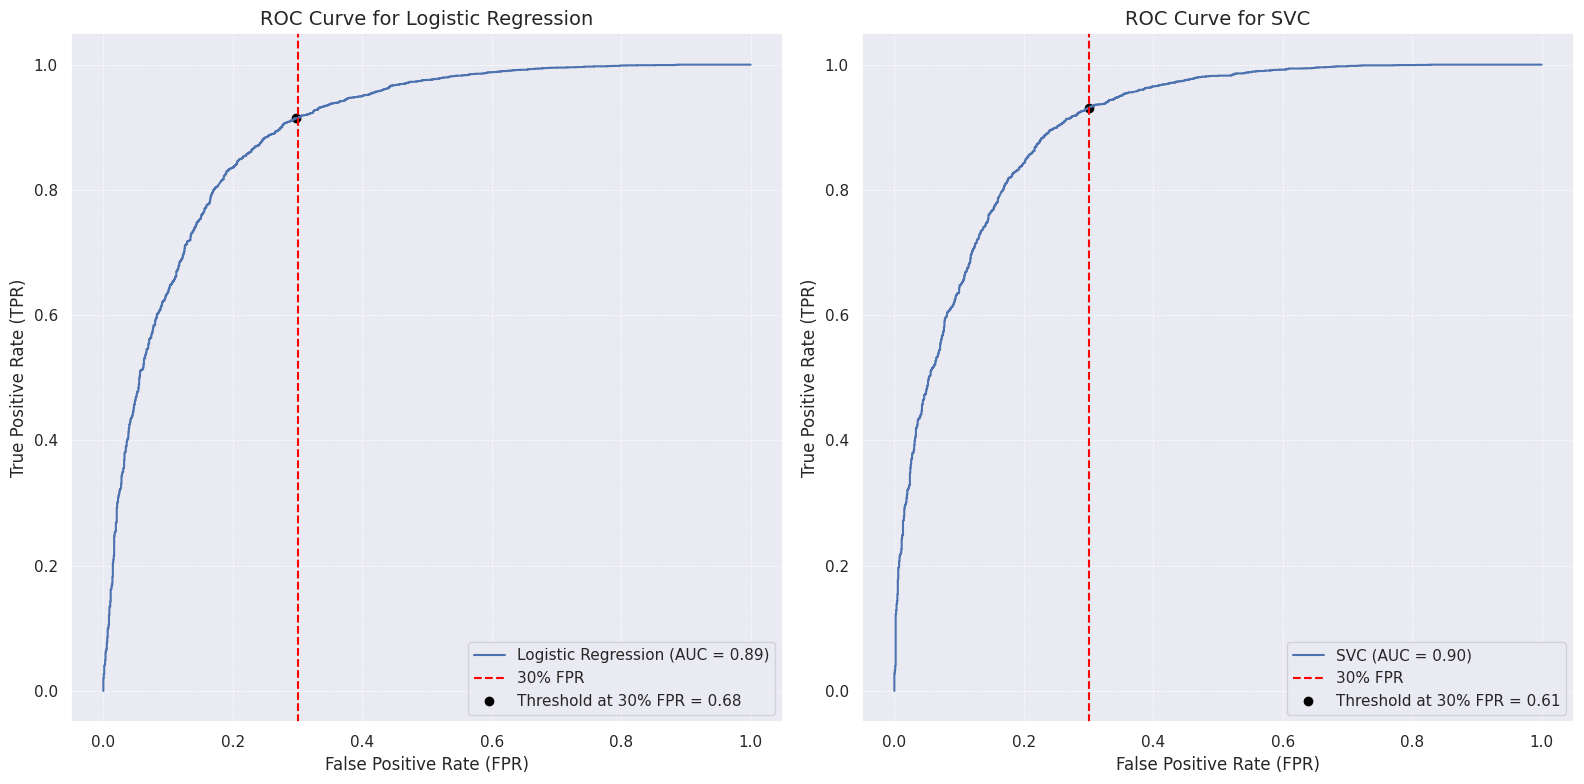


--- ROC Curve Analysis ---
Logistic Regression AUC: 0.89
Threshold for Logistic Regression at 30% FPR: 0.68
SVC AUC: 0.90
Threshold for SVC at 30% FPR: 0.61


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

binary_df = df[df['author'].isin(['Pushkin', 'Dostoevsky'])].copy()
binary_df['author'] = binary_df['author'].map({'Pushkin': 0, 'Dostoevsky': 1})

# Vectorize  TF-IDF
X = binary_df['processed_sentence']
y = binary_df['author']
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42, stratify=y)

best_logistic = LogisticRegression(C=1, random_state=42)
best_svc = SVC(C=1, kernel='linear', probability=True, random_state=42)

# Fit models
best_logistic.fit(X_train, y_train)
best_svc.fit(X_train, y_train)

# predicted probabilities for ROC curves
y_scores_lr = best_logistic.predict_proba(X_test)[:, 1]
y_scores_svc = best_svc.predict_proba(X_test)[:, 1]

#  ROC curves
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_scores_lr)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_scores_svc)

#  AUC
auc_lr = auc(fpr_lr, tpr_lr)
auc_svc = auc(fpr_svc, tpr_svc)

# thresholds for 30% FPR for both models
threshold_lr_30_fpr = thresholds_lr[np.max(np.where(fpr_lr <= 0.3))]
threshold_svc_30_fpr = thresholds_svc[np.max(np.where(fpr_svc <= 0.3))]


plt.figure(figsize=(16, 8))

# Logistic Regression ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', linewidth=1.5)
plt.axvline(x=0.3, color='red', linestyle='--', label='30% FPR')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Logistic Regression', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)

# the threshold at 30% FPR
plt.scatter([fpr_lr[np.max(np.where(fpr_lr <= 0.3))]], [tpr_lr[np.max(np.where(fpr_lr <= 0.3))]],
            color='black', marker='o', label=f'Threshold at 30% FPR = {threshold_lr_30_fpr:.2f}')
plt.legend()

# SVC ROC
plt.subplot(1, 2, 2)
plt.plot(fpr_svc, tpr_svc, label=f'SVC (AUC = {auc_svc:.2f})', linewidth=1.5)
plt.axvline(x=0.3, color='red', linestyle='--', label='30% FPR')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for SVC', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)

# the threshold at 30% FPR
plt.scatter([fpr_svc[np.max(np.where(fpr_svc <= 0.3))]], [tpr_svc[np.max(np.where(fpr_svc <= 0.3))]],
            color='black', marker='o', label=f'Threshold at 30% FPR = {threshold_svc_30_fpr:.2f}')
plt.legend()

plt.tight_layout()
plt.show()


print("\n--- ROC Curve Analysis ---")
print(f"Logistic Regression AUC: {auc_lr:.2f}")
print(f"Threshold for Logistic Regression at 30% FPR: {threshold_lr_30_fpr:.2f}")
print(f"SVC AUC: {auc_svc:.2f}")
print(f"Threshold for SVC at 30% FPR: {threshold_svc_30_fpr:.2f}")



1. **Model Comparison:**
   - **AUC Scores:** SVC (AUC = 0.90) little outperforms Logistic Regression (AUC = 0.89), shwing marginally better discriminative power.
   - **Threshold at 30% FPR:** SVC need a lower threshold (0.66) than Logistic Regression (0.69) to achieve a 30% FPR, showing that SVC is more conservative at this FPR level.

2. **Performance:**
   - Both models have high AUC values, meaning they are effective in distinguishing between Pushkin and Dostoevsky's sentences.
   - SVC's slightly better AUC suggests it may provide marginally better performance in this binary classification task.


3. **So:**
   - **SVC** is the little better performing model based on AUC and threshold behavior.

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

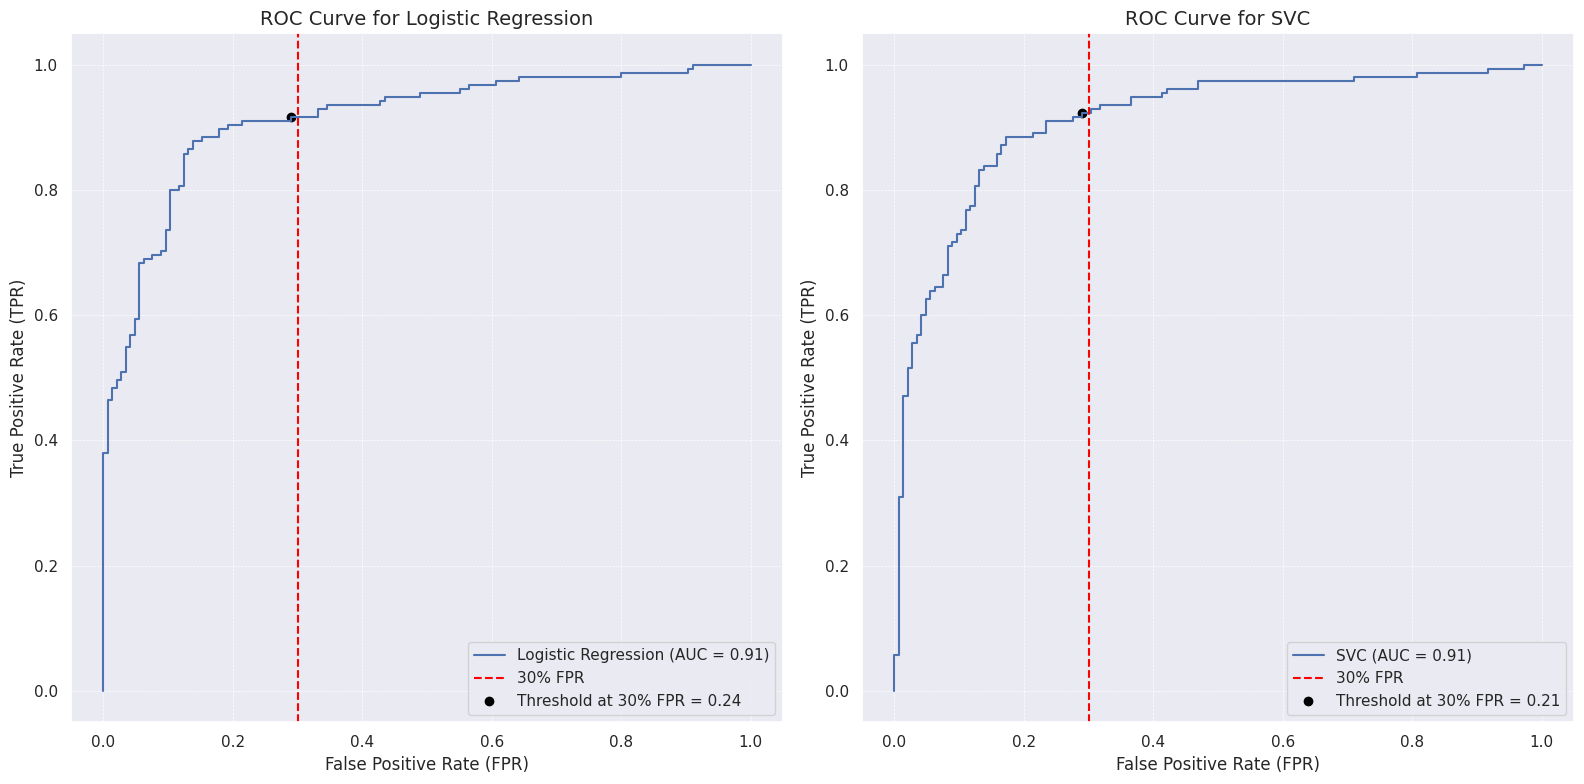

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# synthetic binary classification data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


lr_model = make_pipeline(StandardScaler(), LogisticRegression())
svc_model = make_pipeline(StandardScaler(), SVC(probability=True))

lr_model.fit(X_train, y_train)
svc_model.fit(X_train, y_train)

#  probabilities for ROC curves
y_scores_lr = lr_model.predict_proba(X_test)[:, 1]
y_scores_svc = svc_model.predict_proba(X_test)[:, 1]

#  ROC curves
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_scores_lr)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_scores_svc)

#  AUC
auc_lr = auc(fpr_lr, tpr_lr)
auc_svc = auc(fpr_svc, tpr_svc)

# the threshold for 30% FPR for both models
threshold_lr_30_fpr = thresholds_lr[np.max(np.where(fpr_lr <= 0.3))]
threshold_svc_30_fpr = thresholds_svc[np.max(np.where(fpr_svc <= 0.3))]


plt.figure(figsize=(16, 8))

# Logistic Regression ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', linewidth=1.5)
plt.axvline(x=0.3, color='red', linestyle='--', label='30% FPR')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Logistic Regression', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)


plt.scatter([fpr_lr[np.max(np.where(fpr_lr <= 0.3))]], [tpr_lr[np.max(np.where(fpr_lr <= 0.3))]],
            color='black', marker='o', label=f'Threshold at 30% FPR = {threshold_lr_30_fpr:.2f}')
plt.legend()

# SVC ROC
plt.subplot(1, 2, 2)
plt.plot(fpr_svc, tpr_svc, label=f'SVC (AUC = {auc_svc:.2f})', linewidth=1.5)
plt.axvline(x=0.3, color='red', linestyle='--', label='30% FPR')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for SVC', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)


plt.scatter([fpr_svc[np.max(np.where(fpr_svc <= 0.3))]], [tpr_svc[np.max(np.where(fpr_svc <= 0.3))]],
            color='black', marker='o', label=f'Threshold at 30% FPR = {threshold_svc_30_fpr:.2f}')
plt.legend()

plt.tight_layout()
plt.show()


1. **ROC Curves and AUC**:
   - Both models (Logistic Regression and SVC) have ROC curves plotted with AUC = 0.91, so they have strong classification performance.

2. **Threshold at 30% FPR**:
   - Threshold for Logistic Regression at 30% FPR is 0.24.
   - Threshold for SVC at 30% FPR is 0.21.
   - These thresholds are marked on the ROC curves.


### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [19]:
!pip install --upgrade transformers


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters:
{'classifier__estimator__C': 10, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 1)}


<Figure size 800x600 with 0 Axes>

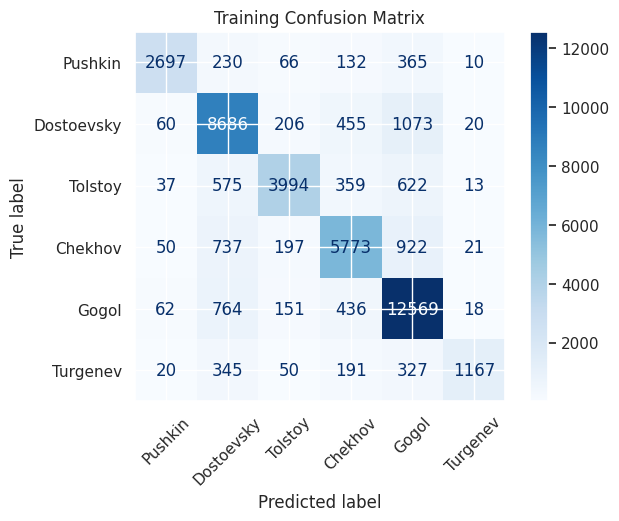

<Figure size 800x600 with 0 Axes>

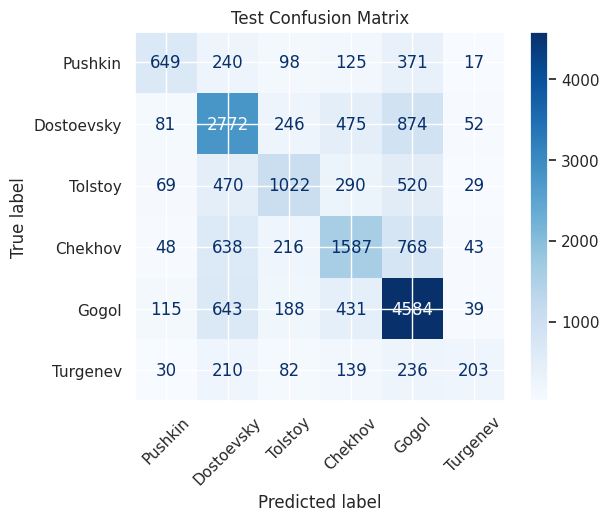


One-Vs-One Logistic Regression Classifier - Test Sample Metrics:
Accuracy: 58.16%
Precision (Weighted): 57.80%
Recall (Weighted): 58.16%
F1 Score (Weighted): 57.11%

Classification Report :) :
              precision    recall  f1-score   support

     Pushkin       0.65      0.43      0.52      1500
  Dostoevsky       0.56      0.62      0.59      4500
     Tolstoy       0.55      0.43      0.48      2400
     Chekhov       0.52      0.48      0.50      3300
       Gogol       0.62      0.76      0.69      6000
    Turgenev       0.53      0.23      0.32       900

    accuracy                           0.58     18600
   macro avg       0.57      0.49      0.51     18600
weighted avg       0.58      0.58      0.57     18600



In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.linear_model import LogisticRegression

try:
    df
except NameError:
    raise Exception("No df")

# Filter and encode authors
selected_authors = ['Pushkin', 'Dostoevsky', 'Tolstoy', 'Chekhov', 'Gogol', 'Turgenev']
multi_df = df[df['author'].isin(selected_authors)].copy()
multi_df = multi_df[['processed_sentence', 'author']].dropna()
author_mapping = {author: idx for idx, author in enumerate(selected_authors)}
multi_df['author'] = multi_df['author'].map(author_mapping)

X = multi_df['processed_sentence']
y = multi_df['author']

# Split the data into training and testing sets with a 0.7 split rate
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', OneVsOneClassifier(LogisticRegression(solver='liblinear')))
])

# parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__estimator__C': [0.1, 1, 10]
}

#  GridSearchCV to find the best parameters (by F1 score)
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_pipeline = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)

# predictions on training and testing sets
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# confusion matrix for the training set
plt.figure(figsize=(8, 6))
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=selected_authors)
disp_train.plot(cmap='Blues', xticks_rotation=45)
plt.title("Training Confusion Matrix")
plt.show()

# confusion matrix for the test set
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=selected_authors)
disp_test.plot(cmap='Blues', xticks_rotation=45)
plt.title("Test Confusion Matrix")
plt.show()

#  metrics for the test sample
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print("\nOne-Vs-One Logistic Regression Classifier - Test Sample Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision * 100:.2f}%")
print(f"Recall (Weighted): {recall * 100:.2f}%")
print(f"F1 Score (Weighted): {f1 * 100:.2f}%")


print("\nClassification Report :) :")
print(classification_report(y_test, y_test_pred, target_names=selected_authors, zero_division=0))



1. **Model Performance**:
   - The **One-Vs-One Logistic Regression classifier** achieved an accuracy of 57.58% on the test set.
   - **Weighted Precision**: 57.28%
   - **Weighted Recall**: 57.58%
   - **Weighted F1 Score**: 56.59%
   - This tells moderate performance across the six authors. ( 8) )

2. **Confusion Matrix**:
   - **Gogol** has the highest classification accuracy in both training and test sets, with fewer misclassifications.
   - **Turgenev** and **Pushkin** show more misclassification, mainly on the test set, so it means that their styles are harder for the model to distinguish from others.

3. **Author-Specific Metrics**:
   - **Gogol**: Highest recall (0.75) and F1 score (0.68) on the test set, well it means the model is better at recognizing Gogol's style.
   - **Turgenev**: Lowest recall (0.21) and F1 score (0.30), showing difficulty in correctly classifying Turgenev's sentences.

4. **Training vs. Test Performance**:
   - The model performs better on the training set than on the test set, some overfitting or that the model struggles with generalization.

5. **So**:
   - The classifier shows kinda moderate classification ability, with Gogolss style being more easily identifiable, while similar styles (like Pushkin and Turgenev) lead to higher misclassification rates.